### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

### Loading/Visualizing Data
Functionality to load the test dataset and labels as numpy arrays and visualize any given image from the numpy array has been implemented in the model_architectures.py file for easy access.

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
# Test visualizer with an image available in test data
viz = Visualizer()
# MNIST
i = 1
print(f"MNIST Shape: {mnist_test_images[i].shape}")
print(f"MNIST Label: {mnist_test_labels[i]}")
viz.show(mnist_test_images[i])

# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
print(f"\nCIFAR-10 Shape: {cifar10_test_images[i].shape}")
print(f"CIFAR-10 Label: {label_mapping[cifar10_test_labels[i]]}")
viz.show(cifar10_test_images[i])

# SVHN
print(f"\nSVHN Shape: {svhn_test_images[i].shape}")
print(f"SVHN Label: {svhn_test_labels[i]}")
viz.show(svhn_test_images[i])


### Testing Our Models (Unperturbed Data)
The data is converted to PyTorch tensors and loaded with a Data Loader for the model to be evaluated. The model can only take in Data Loaders to iterate through the data so after perturbations, we have to load it with the data loader and then evaluate the model. We can verify our models by evaluating the clean test sets and checking the accuracy is equal to our expected accuracies: 99% for MNIST, 76% for CIFAR10, and 93% for SVHN. 

In [6]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [7]:
acc_mnist = tester.test(mnist_resnet_model, test_loader_mnist)
print(f'Test Accuracy MNIST: {acc_mnist * 100:.2f}%')

In [8]:
acc_cifar10 = tester.test(cifar_resnet_model, test_loader_cifar10)
print(f'Test Accuracy CIFAR10: {acc_cifar10 * 100:.2f}%')

In [9]:
acc_svhn = tester.test(svhn_resnet_model, test_loader_svhn)
print(f'Test Accuracy SVHN: {acc_svhn * 100:.2f}%')

### Perturbing an Image and Testing Accuracy
As a simple test we'll just flip the image so it's reversed. In this process we use perturb to modify the images and then reload it with a Data Loader and test it against our model.


In [10]:
def test_flip(images):
    """
    Flip images along the specified axis.

    Parameters:
    - images: numpy array with shape (num_images, channels, height, width)
    - axis: Axis along which to flip the images (0 for vertical, 1 for horizontal)

    Returns:
    - Perturbed images
    """
    flip_axis = 1

    perturbed_images = np.empty_like(images)
    for i in range(images.shape[0]):
        perturbed_image = np.flip(images[i, 0, :, :], axis=flip_axis)
        perturbed_images[i, 0, :, :] = perturbed_image
    return perturbed_images


flipped_images_array = test_flip(mnist_test_images)
# Show example of the image after being flipped
viz.show(flipped_images_array[1])

flipped_images_tensor = loader.convert_mnist_numpy_to_tensor(flipped_images_array, mnist_test_labels)
acc_mnist_flipped = tester.test(mnist_resnet_model, flipped_images_tensor)
print(f'Test Accuracy MNIST (Flipped): {acc_mnist_flipped * 100:.2f}%')
# Accuracy drops 50% but the image is obviously the same

### Fast Gradient Sign Method
The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}
\text{perturbed\_image} &= \text{image} + \epsilon \cdot \text{sign}(\text{data\_grad}) \\
&x = x + \epsilon \cdot \text{sign}(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))
\end{align}

Fast Gradient Sign Method uses $L^∞$ Norm Perturbations

In [11]:
def test_fgsm(model, test_loader, epsilon):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Epsilon: {epsilon}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            loss = F.nll_loss(output, label)
            model.zero_grad()
            loss.backward()
            data_grad = image.grad.data
            perturbed_data = fgsm_attack(image, epsilon, data_grad)

            output_final, _ = model(perturbed_data)
            _, final_pred = torch.max(output_final.data, 1)
            if torch.equal(final_pred, label):
                correct += 1
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            total +=1 

    accuracy = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [12]:
epsilons = [0, .05, .1, .15, .2, .25, .5]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm(mnist_resnet_model, test_loader_mnist, eps)
    accuracies.append(acc)
    examples.append(ex)

print(accuracies)

In [13]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


In [14]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### DeepFool
The `deepfool_attack` function is designed to generate adversarial examples using the DeepFool algorithm. It iteratively picks the classified label closest to the true label that isn't the true label and then uses the gradient to move the image closer to that classification boundary while retaining image data as much as possible. It is considered a "perfect" algorithm as it terminates when the image misclassifies but we limit resources because this could take unreasonable amounts of time in theory. 

\begin{array}{l}
\textbf{while } sign(f(x_i)) = sign(f(x_0)): \\
\hspace{2em} r_i = - \frac{f(x_i)}{\|\nabla f(x_i)\|_2^2} \cdot \nabla f(x) \\
\hspace{2em} x_{i+1} = x_i + r_i \\
\hspace{2em} i = i + 1
\end{array}

Deepfool uses $L^2$ Norm Perturbations


In [15]:
def test_deepfool(model, test_loader, overshoot=0.02):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            perturbed_image, final_pred, r_total, iter = deepfool_attack(image, model, overshoot=0.02, max_iterations=100)
            print(f"Perturbed Iteration: {iter}")
            if torch.equal(final_pred, label):
                correct += 1
            total +=1 

    accuracy = correct / total
    print(f"Test Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [16]:
accuracy = test_deepfool(cifar_resnet_model, test_loader_cifar10)

### Projected Gradient Descent
Projected Gradient Descent is an optimization algorithm that iteratively computes the gradient of the loss and perturbs the image in the direction of the loss gradient. This algorithm has unique hyperparameters. We have a value $α$ which controls the step size the image moves along the gradient, but we also have something known as the $ϵ$-ball. Around the image in the vector space exists a multi dimensional threshold where the image is still percievable to humans. We clip the perturbed output image such that it always exists within this epsilon ball, and we can expand or shrink the epsilon to tune results.

\begin{array}{l}
\textbf{while } t < \text{ iterations:} \\
\hspace{2em} x_{t+1} = Clip(x_t + \alpha \cdot sign(\nabla_x J(\theta, x_t, y)), x, x + \epsilon)
\end{array}

PGA uses uses $L^∞$ Norm Perturbations and MUST be used against  classifiers.

In [32]:
def test_pgd(model, test_loader, epsilon, alpha):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Epsilon: {epsilon}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            

            output_final, perturbed_data = pgd_attack(image, model, init_pred, epsilon, alpha)
            _, final_pred = torch.max(output_final.data, 1)
            if torch.equal(final_pred, label):
                correct += 1
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            print(f"{correct}/{total}")
            total +=1 
            # break
        # break

    accuracy = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [38]:
accuracy, examples = test_pgd(mnist_resnet_model, test_loader_mnist, 8, 0.05 )
print(accuracy)


Batch: 1, Epsilon: 8, Correct: 0
0/0
1/1
1/2
2/3
2/4
2/5
3/6
3/7
3/8
4/9
4/10
4/11
5/12
6/13
7/14
7/15
7/16
8/17
8/18
9/19
9/20
9/21
10/22
10/23
10/24
10/25
10/26
11/27
11/28
11/29
12/30
13/31
13/32
13/33
14/34
15/35
15/36
16/37
16/38
16/39
17/40
17/41
18/42
18/43
19/44
20/45
20/46
21/47
21/48
22/49
23/50
23/51
24/52
25/53
26/54
27/55
28/56
28/57
28/58
28/59
29/60
29/61
29/62
29/63
29/64
29/65
30/66
30/67
31/68
32/69
32/70
33/71
34/72
34/73
35/74
36/75
37/76
38/77
38/78
38/79
38/80
38/81
39/82
40/83
41/84
42/85
43/86
43/87
43/88
43/89
44/90
44/91
44/92
44/93
45/94
45/95
45/96
46/97
46/98
47/99
47/100
48/101
48/102
49/103
49/104
50/105
51/106
51/107
52/108
53/109
53/110
53/111
54/112
55/113
56/114
56/115
57/116
58/117
58/118
58/119
58/120
58/121
59/122
60/123
60/124
60/125
61/126
62/127
62/128
63/129
64/130
64/131
64/132
64/133
64/134
64/135
65/136
65/137
65/138
65/139
65/140
66/141
66/142
67/143
67/144
68/145
68/146
69/147
70/148
70/149
71/150
71/151
71/152
72/153
73/154
74/155
75/156


(7, 9, array([[0.        , 0.        , 0.        , 0.1       , 0.1       ,
        0.1       , 0.        , 0.        , 0.        , 0.1       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.1       , 0.        , 0.1       ],
       [0.        , 0.        , 0.        , 0.        , 0.1       ,
        0.        , 0.        , 0.1       , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.1       , 0.        ,
        0.        , 0.1       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.1       , 0.        , 0.1       ,
        0.        , 0.1       , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.1       , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ,

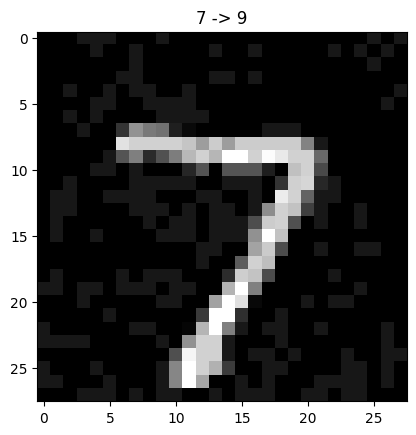

In [39]:
print(examples[0])
true_label = examples[0][0]
false_label = examples[0][1]
image_data = examples[0][2]  # Replace with your actual image data

# Plot the image
plt.imshow(image_data, cmap='gray')  # Assuming the image is grayscale, adjust cmap as needed

# Set the title
title = f"{true_label} -> {false_label}"
plt.title(title)

# Display the plot
plt.show()